In [1]:
%matplotlib inline
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import pandas as pd
import seaborn as sns

In [2]:
t = np.linspace(0,10,2000)

In [3]:
k = 2
b = 2
x0 = [5,0]

In [4]:
def fun(xi,t):
    x = xi[0]
    v = xi[1]
    return [xi[1],-k*xi[0]-b*xi[1]]

In [5]:
sol = odeint(fun, x0, t)

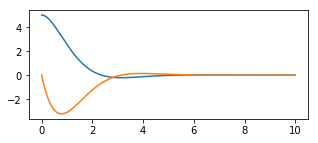

In [6]:
plt.figure(figsize=(5,2))
plt.plot(t,sol)

In [7]:
Sigma = np.array([[5,0],[0,5]])
mu = np.array([0,0])
tau = 0.1
#
N = 40
u = np.linspace(-10,10,N)
v = np.linspace(-10,10,N)
U,V = np.meshgrid(u,v)
#
P = np.zeros((N,N))
P_exp = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        x = np.array([U[i,j],V[i,j]])
        P[i,j] = multivariate_normal.pdf(x,mu,Sigma)
        P_exp[i,j] = 1- np.exp(-tau*np.linalg.norm(x))

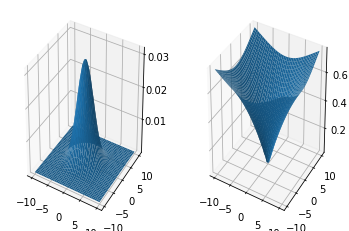

In [8]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(U, V, P)
ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(U, V, P_exp)

In [9]:
def CumExpDist(t,tau):
    return 1 - np.exp(-tau*t)
def SpatialExpDist(x,tau):
    return 1- np.exp(-tau*np.linalg.norm(x))
#
p_sol = np.array([multivariate_normal.pdf(sol[i],mu,Sigma) for i in range(len(sol))])#np.array([SpatialExpDist(sol[i],0.01) for i in range(len(sol))])#
p_t = np.array([CumExpDist(t[i],0.2) for i in range(len(sol))])
P = np.multiply(p_sol,p_t)
Event_flag = np.array([np.random.binomial(1,P[i]) for i in range(len(sol))])

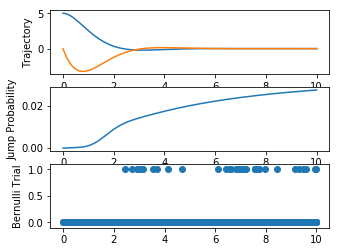

In [11]:
plt.figure(figsize=(5,4))
plt.subplot(311)
plt.plot(t,sol)
plt.ylabel('Trajectory')
plt.subplot(312)
plt.plot(t,P)
plt.ylabel('Jump Probability')
plt.subplot(313)
plt.ylabel('Bernulli Trial')
plt.scatter(t,Event_flag)

In [12]:
Event_index = []
for i in range(len(Event_flag)):
    if Event_flag[i]>0:
        Event_index.append(i)
Event_states = sol[Event_index]

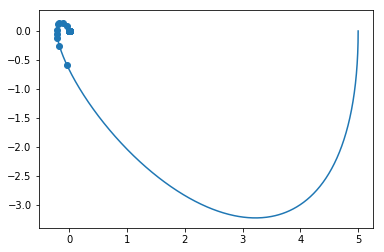

In [13]:
plt.figure()
plt.plot(sol[:,0],sol[:,1])
plt.scatter(Event_states[:,0],Event_states[:,1])

In [14]:
#jump map
def jump(x,t):
    mu = (x + 1*np.random.randn(1,2)).tolist()
    Sigma = [[5,0],[0,5]]
    return np.random.multivariate_normal(mu[0],Sigma)

In [15]:
# integrate the hybrid system
max_events = 5000
event_counter = 0
t = np.linspace(0,10,1000)
x_tot = [0,0,0]
x_event = [0,0,0]
x_reset = [0,0]
t_tot = []
while event_counter<max_events:
    sol = odeint(fun,x0,t)
    for i in range(len(sol)):
        P = multivariate_normal.pdf(sol[i],mu,Sigma)*CumExpDist(t[i],0.4)
        Event = np.random.binomial(1,P)
        if Event:
            flag = 1;
            x0 = jump(sol[i],t[i])
            x_event = np.vstack((x_event,np.hstack((sol[i],t[i]))))
            x_reset = np.vstack((x_reset,x0))
            break
    x_tot = np.vstack((x_tot,np.hstack((sol[:i],t[:i].reshape(i,1)))))
    if event_counter==0:
        t_tot = np.hstack((t_tot,t[:i])) 
        
    else:
        t_tot = np.hstack((t_tot,t[:i]+t_tot[-1]))
    if flag:
        flag = 0
        event_counter += 1
    else:
        x0 = sol[-1]

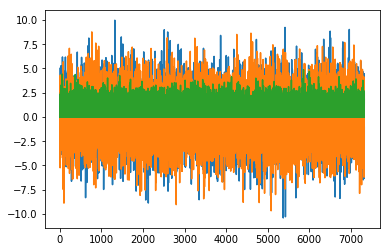

In [16]:
Ttot = t_tot
Xtot = x_tot[1:]
Xtot.shape
plt.figure()
plt.plot(Ttot.reshape(len(Ttot),1),Xtot[:len(Ttot)]);

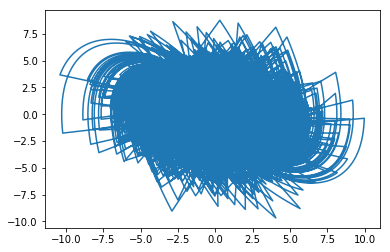

In [17]:
plt.figure()
plt.plot(x_tot[1:,0],x_tot[1:,1]);
plt.scatter(x_event[1:,0],x_event[1:,1]);

Text(0.5, 49.99999999999995, 'x')

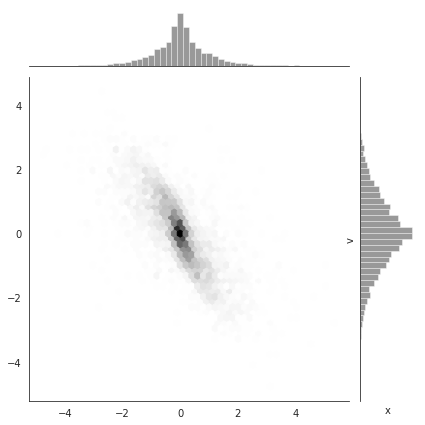

In [24]:
with sns.axes_style("white"):
    sns.jointplot(x=x_event[1:,0], y=x_event[1:,1], kind="hex", color="k");
plt.ylabel('v')
plt.xlabel('x')

Text(0.5, 0, 'event time')

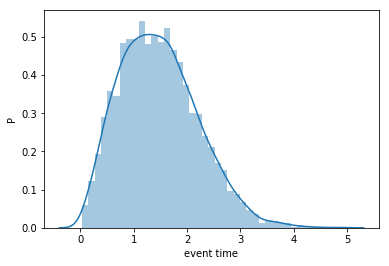

In [22]:
plt.figure()
sns.distplot(x_event[1:,2]);
plt.ylabel('P')
plt.xlabel('event time')

In [ ]:
from scipy import stats
x = x_event[1:,0]
y = x_event[1:,1]
z = x_event[1:,2]

xyz = np.vstack([x,y,z])
density = stats.gaussian_kde(xyz)(xyz) 

idx = density.argsort()
x, y, z, density = x[idx], y[idx], z[idx], density[idx]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=density)
plt.show()

In [ ]:
#x_event.mean(0)
Se = x_event[1:,:2].T.dot(x_event[1:,:2])/len(x_event)